<a href="https://colab.research.google.com/github/plaban1981/POCs/blob/main/Unsupervised_Keyphrase_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keyword Extraction
Keyword Extraction is one of the simplest ways to leverage text mining for providing business value.


## Unsupervised Keyword Extraction Pipeline:

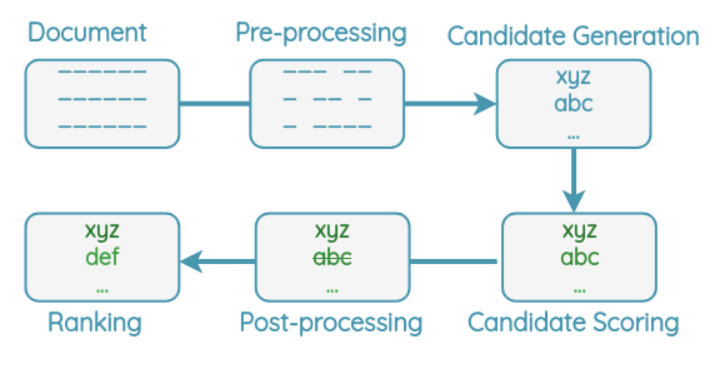


#### Steps
* A document is preprocessed to remove less informative words like stop words, punctuation, and split into terms. 

* Candidate keywords such as words and phrases are chosen.

* A score is determined for each candidate keyword using some algorithm

* The highest-ranking keywords are selected and post-processing such as removing near-duplicates is applied.

* The algorithm returns the top N ranking keywords as output.



## Unsupervised Methods

* Unsupervised algorithms for keyword extraction don’t need to be trained on the corpus and don’t need any pre-defined rules, dictionary, or thesaurus. 
* They can use statistical features from the text itself and as such can be applied to large documents easily without re-training.

* Most of these algorithms don’t need any linguistic features except for stop word lists and so can be applied to multiple languages.

## PKE ( Python Keywork Extractor)

https://boudinfl.github.io/pke/build/html/unsupervised.html#multipartiterank

In [4]:
!pip install --quiet git+https://github.com/boudinfl/pke.git@dc4d5f21e0ffe64c4df93c46146d29d1c522476b
!pip install --quiet flashtext==2.7

     |████████████████████████████████| 235 kB 14.9 MB/s 


In [1]:
text = "On November 8 2016 India announced demonetization. As per the announcement all Rs 500 Rs 1000 high value notes became invalid by midnight. There were three main economic objectives of demonetisation—fighting black money fake notes and creating a cashless economy by pushing digital transactions. Demonetisation is an act of cancelling the legal tender status of a currency unit in circulation. Anticipating positive changes on the liquidity structure as a whole nations often adopt Demonetisation policy as a measure to counterbalance the current economic condition. Countries across the globe have used Demonetisation at some or the other point to control situations such as inflation and to boost economy."

## Textwrap 
* textwrap splits long sentences into smaller chunks for better visualization

In [3]:
import textwrap
wrapper = textwrap.TextWrapper(width=100)
word_list = wrapper.wrap(text=text)
for element in word_list: 
  print(element) 

On November 8 2016 India announced demonetization. As per the announcement all Rs 500 Rs 1000 high
value notes became invalid by midnight. There were three main economic objectives of
demonetisation—fighting black money fake notes and creating a cashless economy by pushing digital
transactions. Demonetisation is an act of cancelling the legal tender status of a currency unit in
circulation. Anticipating positive changes on the liquidity structure as a whole nations often adopt
Demonetisation policy as a measure to counterbalance the current economic condition. Countries
across the globe have used Demonetisation at some or the other point to control situations such as
inflation and to boost economy.


## Import Libraries

In [11]:
import json
import requests
import string
import re
import nltk
import string
import itertools
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import pke
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import traceback
from nltk.tokenize import sent_tokenize
from flashtext import KeywordProcessor
from pprint import pprint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract Keywords including NOUN

In [19]:
def get_noun(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'NOUN'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

noun = get_noun_verb(text)
print ("keywords: ",noun)

keywords:  ['demonetisation', 'value notes became', 'cashless economy', 'transactions', 'fighting', 'pushing', 'creating', 'money', 'notes', 'act']


## Extract Keywords including NOUN

In [20]:
def get_verb(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'VERB'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

verb = get_verb(text)
print ("keywords: ",verb)

keywords:  ['creating', 'pushing', 'fighting', 'counterbalance', 'adopt', 'cancelling', 'control', 'used', 'anticipating', 'boost', 'became', 'announced']


## Extract Keywords including NOUN PROPER NOUN

In [29]:
def get_noun_propn(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'PROPN','NOUN'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

propn_noun = get_noun_propn(text)
print ("keywords: ",propn_noun)

keywords:  ['demonetisation', 'value notes', 'cashless economy', 'transactions', 'money', 'currency unit', 'objectives', 'notes', 'circulation', 'act', 'india', 'countries', 'demonetization', 'tender status', 'midnight', 'condition', 'changes', 'liquidity structure', 'globe', 'nations', 'measure', 'demonetisation policy', 'announcement', 'situations', 'point', 'november', 'inflation', 'economy']


## Extract Keywords including VERB,NOUN

In [21]:
def get_noun_verb(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'VERB','NOUN'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

noun_verbs = get_noun_verb(text)
print ("keywords: ",noun_verbs)

keywords:  ['demonetisation', 'value notes became', 'cashless economy', 'transactions', 'fighting', 'pushing', 'creating', 'money', 'notes', 'act', 'objectives', 'cancelling', 'circulation', 'anticipating', 'currency unit', 'tender status', 'announced demonetization', 'midnight', 'changes', 'liquidity structure', 'nations', 'measure', 'adopt demonetisation policy', 'counterbalance', 'countries', 'condition', 'globe', 'control situations', 'used demonetisation', 'point']


## Extract Keywords including VERB,NOUN,ADJECTIVE

In [22]:
def get_noun_adj_verb(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'VERB', 'ADJ', 'NOUN'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

noun_verbs_adj = get_noun_adj_verb(text)
print ("keywords: ",noun_verbs_adj)

keywords:  ['demonetisation', 'cashless economy', 'pushing digital transactions', 'fighting black money fake notes', 'creating', 'act', 'cancelling', 'legal tender status', 'main economic objectives', 'currency unit', 'circulation', 'anticipating positive changes', 'current economic condition', 'high value notes became invalid', 'whole nations', 'midnight', 'counterbalance', 'measure', 'liquidity structure', 'announced demonetization', 'adopt demonetisation policy', 'countries', 'globe', 'used demonetisation', 'inflation', 'announcement', 'boost economy']


## Extract Keywords including VERB,NOUN,ADJECTIVE,PROPER NOUN,ADVERB

In [23]:
def get_noun_adj_verb_adv(text):
    out=[]
    try:
        extractor = pke.unsupervised.MultipartiteRank()
        extractor.load_document(input=text)
        #    not contain punctuation marks or stopwords as candidates.
        pos = {'VERB', 'ADJ','PROPN' ,'NOUN','ADV'}
        stoplist = list(string.punctuation)
        stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
        stoplist += stopwords.words('english')
        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        # 4. build the Multipartite graph and rank candidates using random walk,
        #    alpha controls the weight adjustment mechanism, see TopicRank for
        #    threshold/method parameters.
        extractor.candidate_weighting(alpha=1.1,
                                      threshold=0.75,
                                      method='average')
        keyphrases = extractor.get_n_best(n=30)
        

        for val in keyphrases:
            out.append(val[0])
    except:
        out = []
        traceback.print_exc()

    return out

noun_verbs_adj_adv = get_noun_adj_verb_adv(text)
print ("keywords: ",noun_verbs_adj_adv)

keywords:  ['demonetisation', 'cashless economy', 'pushing digital transactions', 'fighting black money fake notes', 'creating', 'cancelling', 'act', 'legal tender status', 'india announced demonetization', 'currency unit', 'circulation', 'main economic objectives', 'anticipating positive changes', 'current economic condition', 'high value notes became invalid', 'counterbalance', 'midnight', 'countries', 'globe', 'measure', 'liquidity structure', 'november', 'used demonetisation', 'inflation', 'announcement', 'boost economy']


In [24]:
pprint(noun_verbs_adj_adv)

['demonetisation',
 'cashless economy',
 'pushing digital transactions',
 'fighting black money fake notes',
 'creating',
 'cancelling',
 'act',
 'legal tender status',
 'india announced demonetization',
 'currency unit',
 'circulation',
 'main economic objectives',
 'anticipating positive changes',
 'current economic condition',
 'high value notes became invalid',
 'counterbalance',
 'midnight',
 'countries',
 'globe',
 'measure',
 'liquidity structure',
 'november',
 'used demonetisation',
 'inflation',
 'announcement',
 'boost economy']


In [25]:
pprint(noun_verbs_adj)

['demonetisation',
 'cashless economy',
 'pushing digital transactions',
 'fighting black money fake notes',
 'creating',
 'act',
 'cancelling',
 'legal tender status',
 'main economic objectives',
 'currency unit',
 'circulation',
 'anticipating positive changes',
 'current economic condition',
 'high value notes became invalid',
 'whole nations',
 'midnight',
 'counterbalance',
 'measure',
 'liquidity structure',
 'announced demonetization',
 'adopt demonetisation policy',
 'countries',
 'globe',
 'used demonetisation',
 'inflation',
 'announcement',
 'boost economy']


In [26]:
pprint(noun_verbs)

['demonetisation',
 'value notes became',
 'cashless economy',
 'transactions',
 'fighting',
 'pushing',
 'creating',
 'money',
 'notes',
 'act',
 'objectives',
 'cancelling',
 'circulation',
 'anticipating',
 'currency unit',
 'tender status',
 'announced demonetization',
 'midnight',
 'changes',
 'liquidity structure',
 'nations',
 'measure',
 'adopt demonetisation policy',
 'counterbalance',
 'countries',
 'condition',
 'globe',
 'control situations',
 'used demonetisation',
 'point']


In [30]:
pprint(propn_noun)

['demonetisation',
 'value notes',
 'cashless economy',
 'transactions',
 'money',
 'currency unit',
 'objectives',
 'notes',
 'circulation',
 'act',
 'india',
 'countries',
 'demonetization',
 'tender status',
 'midnight',
 'condition',
 'changes',
 'liquidity structure',
 'globe',
 'nations',
 'measure',
 'demonetisation policy',
 'announcement',
 'situations',
 'point',
 'november',
 'inflation',
 'economy']


In [27]:
pprint(noun)

['demonetisation',
 'value notes became',
 'cashless economy',
 'transactions',
 'fighting',
 'pushing',
 'creating',
 'money',
 'notes',
 'act']


In [28]:
pprint(verb)

['creating',
 'pushing',
 'fighting',
 'counterbalance',
 'adopt',
 'cancelling',
 'control',
 'used',
 'anticipating',
 'boost',
 'became',
 'announced']
